# Notes on Discrete Legendre Orthogonal Polynomials and the Legendre Delay Network Basis ‒ Code Snippets
Andreas Stöckel, December 2020

**License:**  
The code in this Jupyter Notebook is licensed under the Creative Commons Zero license. To the extent possible under law, Andreas Stöckel has waived all copyright and related or neighboring rights to this code. This work is published from: Canada.

In [1]:
import numpy as np

## Plotting Code

In [2]:
# Helper function used to compare the individual bases
def plot_basis(B, varname='T', bottom_labels=True):
    import matplotlib.pyplot as plt
    import matplotlib.patches as mpatches
    plt.rcParams['figure.dpi'] = 200

    height = 2.0 if bottom_labels else 1.6
    fig, axs = plt.subplots(1, 3, figsize=(4.5, height), constrained_layout=True)
    axs[0].imshow(B @ B.T, interpolation='nearest',
                  extent=(0.5, B.shape[0] + 0.5, B.shape[0] + 0.5, 0.5))
    axs[0].set_xticks(np.linspace(1, B.shape[0], 5, dtype=np.int))
    axs[0].set_yticks(np.linspace(1, B.shape[0], 5, dtype=np.int))
    axs[0].set_title("$\\mathbf{{{}}} \\mathbf{{{}}}^T$".format(varname, varname))
    axs[0].set_ylabel("Row $i$")
    if bottom_labels:
        axs[0].set_xlabel("Column $j$")

    axs[1].imshow(B, interpolation='nearest',
                  extent=(0.5, B.shape[1] + 0.5, B.shape[0] + 0.5, 0.5))
    axs[1].set_xticks(np.linspace(1, B.shape[1], 5, dtype=np.int))
    axs[1].set_yticks(np.linspace(1, B.shape[0], 5, dtype=np.int))
    axs[1].set_title("$\\mathbf{{{}}}$".format(varname))
    #axs[1].set_yticklabels([])
    axs[1].set_ylabel("Row $i$")
    axs[1].set_aspect(B.shape[1] / B.shape[0])
    if bottom_labels:
        axs[1].set_xlabel("Column $j$")

    axs[2].plot(np.arange(1, B.shape[1] + 1), B[:6].T);
    axs[2].set_xticks(np.linspace(1, B.shape[1], 3, dtype=np.int))
    axs[2].set_title("First basis vectors $(\\mathbf{{{}}})_i$".format(varname))
    axs[2].set_xlim(1, B.shape[1] + 1)
    if bottom_labels:
        axs[2].set_xlabel("Column $j$")
    xlim, ylim = axs[2].get_xlim(), axs[2].get_ylim()
    w, h = xlim[1] - xlim[0], ylim[1] - ylim[0]
    axs[2].set_aspect(w / h)

    for ax in axs.flat:
        for spine in ["top", "left", "bottom", "right"]:
            ax.spines[spine].set_position(('outward', 5.0))

    return fig, axs

## Legendre Delay Network (LDN)

In [3]:
def mk_ldn_lti(q, dtype=np.float):
    """
    Generates the A, B matrices of the linear time-invariant (LTI) system
    underlying the LDN. 

    The returned A is a q x q matrix, the returned B is a vector of length q.
    Divide the returned matrices by the desired window length theta.

    See Aaron R. Voelker's PhD thesis for more information:
    https://hdl.handle.net/10012/14625 (Section 6.1.3, p. 134)   
    """
    qs = np.arange(q)
    A = -np.ones((q, q), dtype=dtype)
    for d in range(1, q, 2): # iterate over odd diagonals
        A[range(d, q), range(0, q - d)] = 1
    B = np.ones((q,), dtype=dtype)
    B[1::2] = -1
    return (2 * qs[:, None] + 1) * A, \
           (2 * qs + 1) * B

def discretize_lti(dt, A, B):
    """
    Discretizes an LTI system described by matrices A, B under a
    zero-order-hold (ZOH) assumption. The new matrices Ad, Bd can be used in
    the following manner

       x[t + 1] = Ad x[t] + Bd u[t] ,

    i.e., the returned matrices implicitly contain the
    integration step.

    See https://en.wikipedia.org/wiki/Discretization for
    more information.
    """    
    from scipy.linalg import expm
    # See https://en.wikipedia.org/wiki/Discretization
    Ad = expm(A * dt)
    Bd = np.linalg.solve(A, (Ad - np.eye(A.shape[0])) @ B)
    return Ad, Bd

## Legendre Delay Network Basis

In [4]:
def mk_ldn_basis_naive(q, N=None):
    """
    This function is the attempt at generating a LDN basis using naive Euler
    integration. This produces horribly wrong results.
    
    For reference only, DO NOT USE. Use `mk_ldn_basis` instead.
    """
    N = q if N is None else N
    A, B = mk_ldn_lti(q)
    At, Bt = A / N + np.eye(q), B / N
    T = np.zeros((q, N))
    Aexp = np.eye(q)
    for i in range(N):
        T[:, q - i - 1] = Aexp @ Bt
        Aexp = At @ Aexp
    return T

def mk_ldn_basis(q, N=None):
    """
    Generates the LDN basis for q basis vectors and N input samples.
    """
    N = q if N is None else N
    At, Bt = discretize_lti(1.0 / N, *mk_ldn_lti(q))
    T = np.zeros((q, N))
    Aexp = np.eye(q)
    for i in range(N):
        T[:, N - i - 1] = Aexp @ Bt
        Aexp = At @ Aexp
    return T

## Discrete Legendre Orthogonal Polynomial Basis and Related Code

In [5]:
def mk_leg_basis(q, N=None):
    """
    Creates a non-orthogonal basis by simply sampling the Legendre polynomials.
    """
    N = q if N is None else N
    xs = np.linspace(1, -1, N)
    res = np.zeros((q, N))
    for i in range(q):
        res[i] = np.polynomial.Legendre([0] * i + [1])(xs)
    return res / np.linalg.norm(res, axis=1)[:, None]


def mk_dlop_basis_naive(q, N=None):
    """
    Constructs a matrix of "Discrete Legendre Orthogonal Polynomials" (DLOPs).
    q is the number of polynomials to generate, N is the number of samples for
    each polynomial.

    This is function is for reference only and should not be used. It is
    unstable for q > 30 (if N > q the function may be stable longer).

    This function uses a rather inefficient approach that directly relies on
    the definition of a Legendre Polynomial (a set of orthogonal Polynomials
    with Pi(1) = 1.0) to generate the basis.

    In each iteration i, this function adds a new polynomial of degree i to the
    set of already computed polynomials. The polynomial coefficients are
    determined by solving for coefficients that generate discrete sample points
    that are orthogonal to the already sampled sample points.

    The returned basis is made orthogonal by dividing by the norm of each
    discrete polynomial.
    """
    # Construct the sample points
    N = q if N is None else N
    qs, Ns = np.arange(q), np.arange(N)
    xs = 2.0 * Ns / (N - 1.0) - 1.0

    # Evaluate the individual monomials
    M = np.power(xs[:, None], qs[None, :])

    # Create the matrix. The first basis vector
    # is "all ones"
    res = np.zeros((q, N))
    res[0] = 1.0

    # Solve for polynomial coefficients up to
    # degree q such that the newly added basis
    # vector is orthogonal to the already created
    # basis vectors, and such that the last sample
    # is one.
    for i in range(1, q):
        A = np.zeros((i + 1, i + 1))
        b = np.zeros((i + 1,))
        b[-1] = 1.0
        A[:i, :] = res[:i, :] @ M[:, :i+1]
        A[i, :] = M[0, :i+1]
        coeffs = np.linalg.solve(A, b)
        res[i] = M[:, :i+1] @ coeffs

    return res / np.linalg.norm(res, axis=1)[:, None]


def mk_dlop_basis(q, N=None):
    """
    Slow, direct implementation of the DLOP basis according to

    Neuman, C. P., & Schonbach, D. I. (1974).
    Discrete (legendre) orthogonal polynomials—A survey.
    International Journal for Numerical Methods in
    Engineering, 8(4), 743–770.
    https://doi.org/10.1002/nme.1620080406

    Note that this code relies on the fact that Python 3 always uses
    "big ints" or ("long" in Python 2 terms). The integers used in this
    function will likely not fit into 32- or 64-bit integers; so be careful
    when porting this code to a different programing language.
    """

    def fading_factorial(K, m, m0=0):
        # Fading factorial as defined in the paper. The optional m0 parameter
        # defines how many terms are skipped at the beginning. m0 makes
        # computing the corrective factor in the numerator below a little
        # simpler.
        res = 1
        for i in range(m0, m):
            res *= K - i
        return res

    def nCr(n, r):
        # Binomial coefficient (n choose r; nCr is what my trusty pocket
        # calculator calls it).
        return fading_factorial(n, r) // \
               fading_factorial(r, r)

    N = q if N is None else N
    res = np.zeros((q, N))
    for m in range(q):
        # Usa a common denominator instead of dividing by
        # fading_factorial(N - 1, j), where "j" is the inner loop variable.
        # Instead we divide all terms by fading_factorial(N - 1, m) and
        # multiply the terms by the additional terms that we're dividing by.
        denom = fading_factorial(N - 1, m)
        for K in range(N):
            numer = 0
            for j in range(m + 1):
                # Main equation from the paper. The last term corrects for the
                # common denominator.
                c = nCr(m, j) * nCr(m + j, j) * \
                   fading_factorial(K, j) * \
                   fading_factorial(N - 1, m, j)
                numer += c if (j % 2 == 0) else -c
            res[m, K] = numer / denom
        res[m] 

    return res / np.linalg.norm(res, axis=1)[:, None]

## Fourier and Cosine Basis

In [6]:
def mk_fourier_basis(q, N=None):
    """
    Generates the q x N matrix F that can be used to compute a Fourier-like
    transformation of a real-valued input vector of length N.  The first
    result dimension will be the DC offset.  Even result dimensions are the
    real (sine) Fourier coefficients, odd dimensions are the imaginary (cosine)
    coefficients. This is only a proper Fourier transformation for q = N.
    """
    N = q if N is None else N
    qs, Ns = np.arange(q)[:, None], np.arange(N)[None, :]
    freq = ((qs + 1) // 2) # 0, 1, 1, 2, 2, ...
    phase = (qs % 2)       # 0, 1, 0, 1, 0, ...
    F = np.cos(
        2.0 * np.pi * freq * (Ns + 0.5) / N + \
        0.5 * np.pi * phase)
    F[0] /= np.sqrt(2)
    F[-1] /= np.sqrt(2) if (q % 2 == 0 and N == q) else 1.0
    return F * np.sqrt(2 / N)


def mk_cosine_basis(q, N=None):
    """
    Generates the q x N matrix C which can be used to compute the orthogonal
    DCT-II, everyone's favourite basis transformation. As with the
    `mk_fourier_basis` function above, this code only returns a canonical
    DCT basis if q = N.
    """
    N = q if N is None else N
    qs, Ns = np.arange(q)[:, None], np.arange(N)[None, :]
    C = np.cos((Ns + 0.5) / N * qs * np.pi)
    C[0] /= np.sqrt(2)
    return C * np.sqrt(2 / N)

### Fourier and Cosine Basis

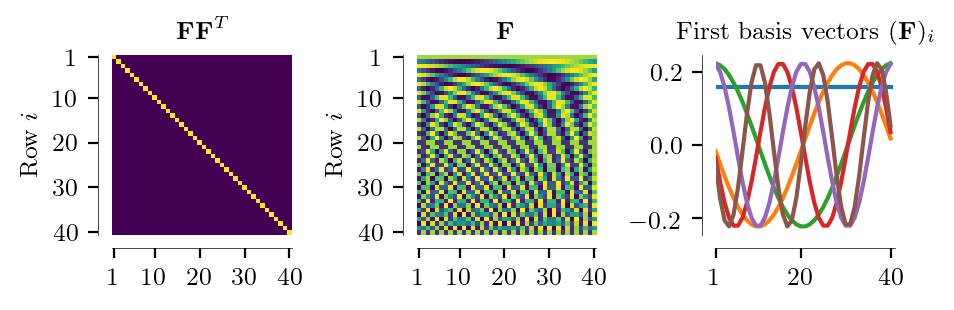

In [7]:
F = mk_fourier_basis(40, 40)
fig_F, _ = plot_basis(F, 'F', bottom_labels=False)

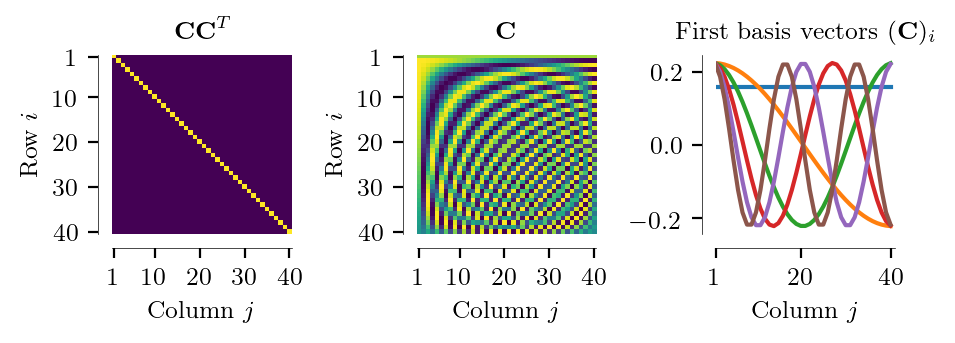

In [8]:
C = mk_cosine_basis(40, 40)
fig_C, axs = plot_basis(C, 'C')

### LDN Basis

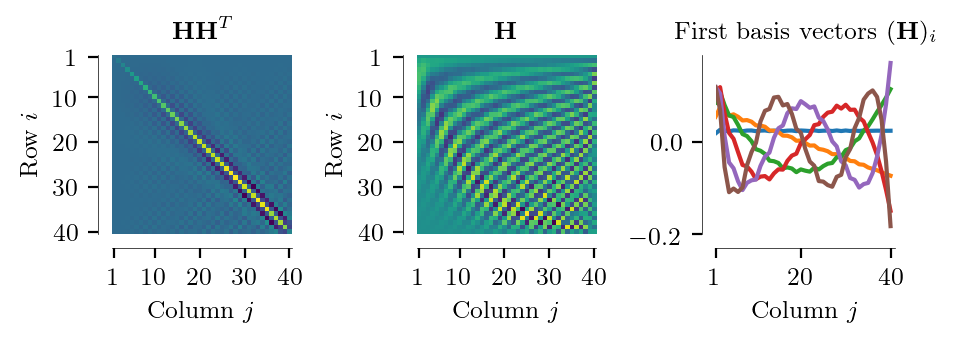

In [9]:
H = mk_ldn_basis(40, 40)
fig_H, axs = plot_basis(H, 'H')

### Discretised Legendre Basis

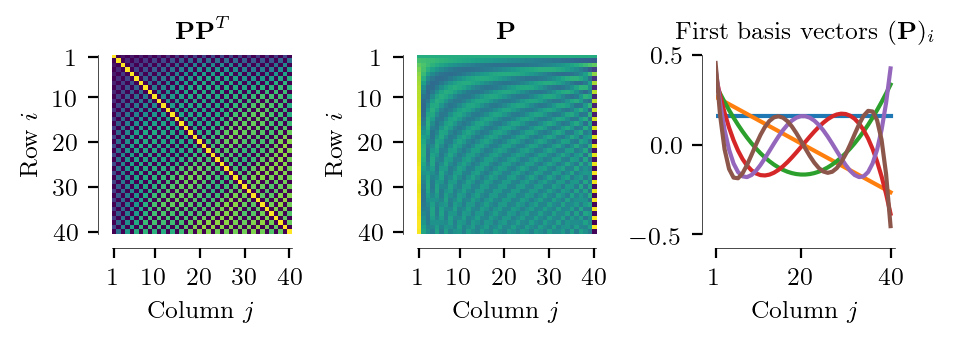

In [10]:
P = mk_leg_basis(40, 40)
fig_P, axs = plot_basis(P, 'P')

### DLOP Basis

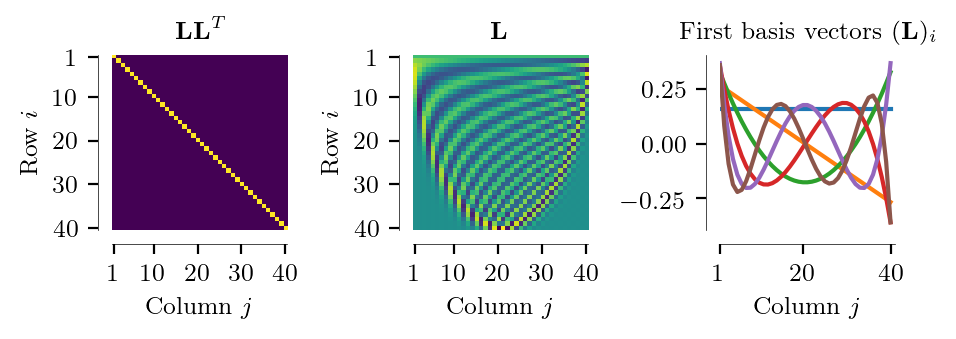

In [11]:
L = mk_dlop_basis(40, 40)
fig_L, axs = plot_basis(L, 'L')

In [12]:
# Used to generate the figures for the TR
fig_F.savefig('../media/fourier_basis_example.pdf', transparent=True, bbox_inches='tight')
fig_C.savefig('../media/cosine_basis_example.pdf', transparent=True, bbox_inches='tight')
fig_H.savefig('../media/legendre_basis_example.pdf', transparent=True, bbox_inches='tight')
fig_P.savefig('../media/leg_basis_example.pdf', transparent=True, bbox_inches='tight')
fig_L.savefig('../media/dlop_basis_example.pdf', transparent=True, bbox_inches='tight')